In [33]:
from athletic_pandas.models import Athlete, WorkoutDataFrame
import matplotlib
import numpy as np

%matplotlib inline

In [34]:
athlete = Athlete(cp=350, w_prime=20000)

In [35]:
warming_up = [100] * 600
intervals = ([400]*60 + [0]*60)*5 + [0]*240 + ([400]*60 + [0]*60)*5
cooling_down = [200] * 600

wdf = WorkoutDataFrame(dict(
    power=warming_up + intervals + cooling_down
))
wdf.athlete = athlete

In [4]:
wdf = wdf.assign(
    w_balance_skiba=wdf.w_prime_balance('skiba'),
    w_balance_waterworth=wdf.w_prime_balance('waterworth'),
    w_balance_froncioni=wdf.w_prime_balance('froncioni'),
)

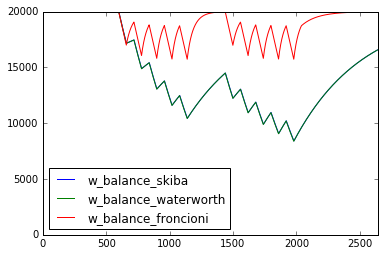

In [12]:
wdf.loc[:, ['w_balance_skiba', 'w_balance_waterworth', 'w_balance_froncioni']].plot(ylim=0)

In [32]:
np.allclose(wdf.w_balance_waterworth, wdf.w_balance_skiba, atol=50)

True